In [1]:
import yfinance as yf
import sklearn
import pandas as pd
import datetime
from finta import TA
import time
import numpy as np

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [2]:
NUM_DAYS = 1000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data

In [3]:
INDICATORS = ['RSI', 'MACD',
              'STOCH', 'ADL',
              'ATR', 'MOM',
              'MFI', 'ROC',
              'OBV', 'CCI',
              'EMV', 'VORTEX']

tickers = ('TSLA', 'GOOGL', 'GME', 'AMZN')

In [4]:
def _get_historical_data(tickers, NUM_DAYS, INTERVAL):
    """
    Function that uses the yfinance API to get stock data
    :return:
    """

    start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
    end = datetime.datetime.today()

#     data = yf.download(ticker, start=start, end=end, interval=INTERVAL)
    data = yf.download(tickers, start=start, end=end, interval=INTERVAL, group_by='Ticker')
    data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    data.rename(columns={"Close": 'close',
                         "Adj Close": 'adj close',
                         "High": 'high',
                         "Low": 'low',
                         'Volume': 'volume',
                         'Open': 'open'},
                inplace=True)
    return data


[*********************100%***********************]  4 of 4 completed


Ticker
AMZN     AxesSubplot(0.125,0.2;0.775x0.68)
GME      AxesSubplot(0.125,0.2;0.775x0.68)
GOOGL    AxesSubplot(0.125,0.2;0.775x0.68)
TSLA     AxesSubplot(0.125,0.2;0.775x0.68)
Name: adj close, dtype: object

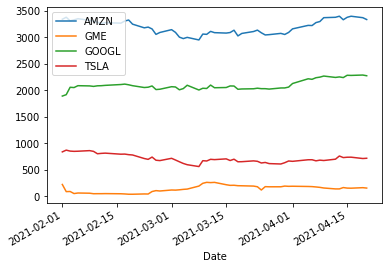

In [5]:
stock_df = _get_historical_data(tickers, NUM_DAYS = 1000, INTERVAL= '1d')
stock_df.last('80D').groupby('Ticker')['adj close'].plot(legend=True)

In [6]:
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    return data.ewm(alpha=alpha).mean()


def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['adj close'])

    return data

def clean_data(df, alpha=0.65):
    """
    Combine all data manipulation functions

    :param df: dataframe
    :param alpha: exponent factor
    :param window: look ahead time in days
    :return:
    Dataframe with features and prediction target
    """
    df = _exponential_smooth(df, alpha=alpha)
    df = _get_indicator_data(df)
#     df.dropna(inplace=True)

    return df

def _produce_prediction(data, window=7):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """

    prediction = (data.close.shift(-window) >= data.close)
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    data.dropna(inplace=True)

    return data

In [7]:
df_list = []
for ticker in tickers:
    df_list.append(
        _produce_prediction(
            (clean_data(stock_df.loc[stock_df.Ticker == ticker]))
        )
    )
    
ml_df = pd.concat(df_list).sort_index(kind='merge')

In [8]:
print(ml_df.tail())
print(ml_df.shape)

                  close  14 period RSI       MACD     SIGNAL  \
Date                                                           
2021-04-08  3284.248643      69.487221  23.946230  -3.781003   
2021-04-09   678.530550      50.586965  -7.780780 -15.813735   
2021-04-09  2260.454668      81.340644  51.311895  29.846072   
2021-04-09   163.806539      46.921593   7.476590  13.840107   
2021-04-09  3341.416993      73.549239  36.395345   4.254267   

            14 period STOCH %K           MFV  14 period ATR         MOM  \
Date                                                                      
2021-04-08           91.720164  9.962980e+07      61.882409  184.554227   
2021-04-09           80.853529  2.899990e+09      29.672948   37.596867   
2021-04-09           96.921387  5.644526e+07      42.444973  227.327091   
2021-04-09           42.613718 -4.383390e+08      28.273608   -5.933151   
2021-04-09           97.462782  1.025406e+08      61.811515  276.454941   

            14 period MFI

In [9]:
X = ml_df.drop('pred', axis = 1)
y = ml_df.pred

In [10]:
clf = RandomForestClassifier(n_estimators=90)
clf.fit(X,y)

RandomForestClassifier(n_estimators=90)

In [11]:
print(np.mean(cross_val_score(clf, X, y, cv=8)))

0.4537581553311288


# Generate prediction

<AxesSubplot:xlabel='Date'>

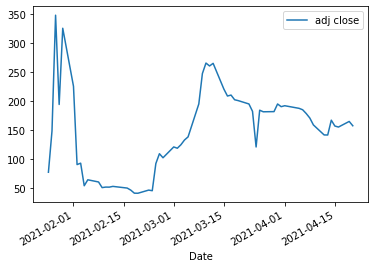

In [12]:
goog_df = stock_df.loc[stock_df.Ticker == 'GME']
goog_df[['adj close']][-60:].plot()

In [13]:
goog_ml_df = _produce_prediction(
    (clean_data(goog_df))
)

X_goog = goog_ml_df.iloc[:, :-1]
y_goog = goog_ml_df.pred

In [14]:
buy_sell = {1: 'Stock going up, buy',
            0: 'Stock going down, sell'}

"This is the prediction for next 7 days:"
pred_df = (clean_data(goog_df))

print(buy_sell[clf.predict(pred_df[-1:])[0]])

Stock going down, sell


In [15]:
clf.predict_proba(pred_df[-1:])[0][1]

0.43333333333333335

In [16]:
print(np.mean(cross_val_score(clf, X_goog, y_goog, cv=8)))

0.45587707974756164


In [18]:
# from sklearn import tree
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=800)
# tree.plot_tree(clf.estimators_[0],
#                feature_names = X.columns, 
#                class_names=y.name,
#                filled = True)

In [19]:
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (50,10), dpi=900)
# for index in range(0, 5):
#     tree.plot_tree(clf.estimators_[index],
#                    feature_names = X.columns, 
#                    class_names=y.name,
#                    filled = True,
#                    ax = axes[index]);

#     axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

In [20]:
len(clf.estimators_)

90

In [21]:
def _get_historical_data_mt(tickers, NUM_DAYS, INTERVAL):
    """
    Function that uses the yfinance API to get stock data
    :return:
    """

    start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
    end = datetime.datetime.today()

    data = yf.download(tickers, start=start, end=end, interval=INTERVAL, group_by='Ticker')
    data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    data.rename(columns={"Ticker":"ticker",
                         "Close": 'close',
                         "Adj Close": 'adj close',
                         "High": 'high',
                         "Low": 'low',
                         'Volume': 'volume',
                         'Open': 'open'},
                inplace=True)
    return data

def _produce_prediction_mt(data, window=7):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    data['pred'] = (data.groupby('ticker').close.shift(-window) >= data.close)
    for t in data.ticker.unique():
      data.loc[data.ticker == t, 'pred'] = data.loc[df.ticker == t, 'pred'].iloc[:-window]
    data.dropna(inplace=True)
    data['pred'] = data['pred'].astype(int)

    return data

In [22]:
import altair as alt

In [23]:
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    alt.X('Date:T', axis=alt.Axis(title='')),
    alt.Y('close:Q', axis=alt.Axis(title='',format='$f')),
    color='symbol:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'price:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
stockChart = alt.layer(line, selectors, points, rules, text,
                       data='https://raw.githubusercontent.com/altair-viz/vega_datasets/master/vega_datasets/_data/stocks.csv', 
                       width=600, height=300,title='Stock History')

In [26]:
ticks = yf.Tickers(list(tickers))

In [30]:
tick = yf.Ticker(tickers[1])

In [39]:
ticks.tickers['TSLA'].info

{'zip': '94304',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 70757,
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and vehicle insurance, as well as sale of products through its subsidiaries to third party customers; services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians; and 

In [42]:
tick.info

{'zip': '94043',
 'sector': 'Communication Services',
 'fullTimeEmployees': 135301,
 'longBusinessSummary': 'Alphabet Inc. provides online advertising services in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. The company offers performance and brand advertising services. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, such as ads, Android, Chrome, hardware, Google Maps, Google Play, Search, and YouTube, as well as technical infrastructure; and digital content. The Google Cloud segment offers infrastructure and data analytics platforms, collaboration tools, and other services for enterprise customers. The Other Bets segment sells internet and TV services, as well as licensing and research and development services. The company was founded in 1998 and is headquartered in Mountain View, California.',
 'city': 'Mountain View',
 'phone': '650-253-0000',
 

In [44]:
datetime.datetime.today().strftime("%A, %d %b %Y")

'Tuesday, 20 Apr 2021'